In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
# drscarlat_melanoma_path = kagglehub.dataset_download('drscarlat/melanoma')
# andrewmvd_isic_2019_path = kagglehub.dataset_download('andrewmvd/isic-2019')

andrewmvd_isic_2019_path = '/content/drive/My Drive/isic-2019'
# surajghuwalewala_ham1000_segmentation_and_classification_path = kagglehub.dataset_download('surajghuwalewala/ham1000-segmentation-and-classification')

print('Data source import complete.')


Data source import complete.


In [ ]:
/# print(drscarlat_melanoma_path)
print(andrewmvd_isic_2019_path)
# print(surajghuwalewala_ham1000_segmentation_and_classification_path)

/content/drive/My Drive/isic-2019


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# os.listdir(drscarlat_melanoma_path)
os.listdir(andrewmvd_isic_2019_path)
# os.listdir(surajghuwalewala_ham1000_segmentation_and_classification_path)


['ISIC_2019_Training_GroundTruth.csv',
 'ISIC_2019_Training_Input',
 'ISIC_2019_Training_Metadata.csv']

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.onnx
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from tqdm import tqdm

In [ ]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda"
                      if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation
columns_rearranged = ['image', 'NV', 'MEL', 'BCC', 'AKIEC', 'DF', 'VASC']

# skin_cancer_df = pd.read_csv('/root/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2/GroundTruth.csv')
# skin_cancer_df.drop(columns=['BKL'], inplace=True)
# skin_cancer_df = skin_cancer_df[columns_rearranged]

# skin_cancer_2019_df = pd.read_csv('/root/.cache/kagglehub/datasets/andrewmvd/isic-2019/versions/1/ISIC_2019_Training_GroundTruth.csv')
skin_cancer_2019_df = pd.read_csv(os.path.join(andrewmvd_isic_2019_path, 'ISIC_2019_Training_GroundTruth.csv'))
skin_cancer_2019_df.drop(columns=['BKL', 'SCC', 'UNK'], inplace=True)
skin_cancer_2019_df.rename(columns={'AK': 'AKIEC'}, inplace=True)
skin_cancer_2019_df = skin_cancer_2019_df[columns_rearranged]



Using device: cuda


In [ ]:
# NV - Melanocytic Nevus: Benign mole from melanocytes.
# MEL - Melanoma: Malignant, high-risk skin cancer from melanocytes.
# BCC - Basal Cell Carcinoma: Common, low-risk skin cancer.
# AKIEC - Actinic Keratosis: Precancerous lesion from sun exposure.
# DF - Dermatofibroma: Benign, fibrous skin growth.
# VASC - Vascular Lesion: Benign growth involving blood vessels.

# BKL - Benign Keratosis
# SCC - Squamous Cell Carcinoma
# UNK

In [ ]:
multiclass_categories = {
    0: 'NV',
    1: 'MEL',
    2: 'BCC',
    3: 'AKIEC',
    4: 'DF',
    5: 'VASC'
}

filenames_list, multiclass_categories_list = [], []

# # base_paths = [
#     ("/root/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2/images", skin_cancer_df),
#     ("/root/.cache/kagglehub/datasets/drscarlat/melanoma/versions/1/DermMel/", [['test', 'valid'], ['NotMelanoma', 'Melanoma']]),
#     ("/root/.cache/kagglehub/datasets/andrewmvd/isic-2019/versions/1/ISIC_2019_Training_Input/ISIC_2019_Training_Input", skin_cancer_2019_df)
# ]


base_paths = [("/content/drive/My Drive/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input", skin_cancer_2019_df)]


In [ ]:
for base_path, database in base_paths:
    if isinstance(database, pd.DataFrame):
        for row in database.itertuples(index=False):
            filename = os.path.join(base_path, row[0]) + '.jpg'
            filenames_list.append(filename)
            multiclass_index = np.argmax(row[1:])
            multiclass_categories_list.append(multiclass_index)
    else:
        for sub_directory in database[0]:
            for sub_sub_directory in database[1]:
                final_path = os.path.join(base_path, sub_directory, sub_sub_directory)
                for filename in os.listdir(final_path):
                    filenames_list.append(os.path.join(final_path, filename))
                    if sub_sub_directory in ['nevus', 'NotMelanoma']:
                        multiclass_categories_list.append(0)
                    else:
                        multiclass_categories_list.append(database[1].index(sub_sub_directory))

multiclass_df = pd.DataFrame({"filename": filenames_list, "category": multiclass_categories_list})
multiclass_df = multiclass_df.sample(frac=1).reset_index(drop=True)

multiclass_class_counts = np.bincount(multiclass_categories_list)
# multiclass_class_weights = {i: len(multiclass_categories_list) / (2.0 * count) for i, count in enumerate(multiclass_class_counts)}
multiclass_class_weights = {i: 1 for i, count in enumerate(multiclass_class_counts)}

print(f"Multi-class weights: {multiclass_class_weights}")

print(len(multiclass_categories_list))
print(multiclass_df['category'].value_counts(normalize=False))  # Check proportions


Multi-class weights: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}
25331
category
0    16127
1     4522
2     3323
3      867
5      253
4      239
Name: count, dtype: int64


In [ ]:
multiclass10percentdf = multiclass_df.groupby('category', group_keys=False).apply(
    lambda x: x.sample(frac=0.1, random_state=42)
)

print(multiclass10percentdf['category'].value_counts(normalize=False))  # Check proportions


category
0    1613
1     452
2     332
3      87
5      25
4      24
Name: count, dtype: int64


<ipython-input-16-5f2105fcc464>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  multiclass10percentdf = multiclass_df.groupby('category', group_keys=False).apply(


<ipython-input-19-83e034af0667>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni, x=uni.index, y='Count', palette='icefire', width=0.4).set_title('Class distribution in Dataset', fontsize=15)


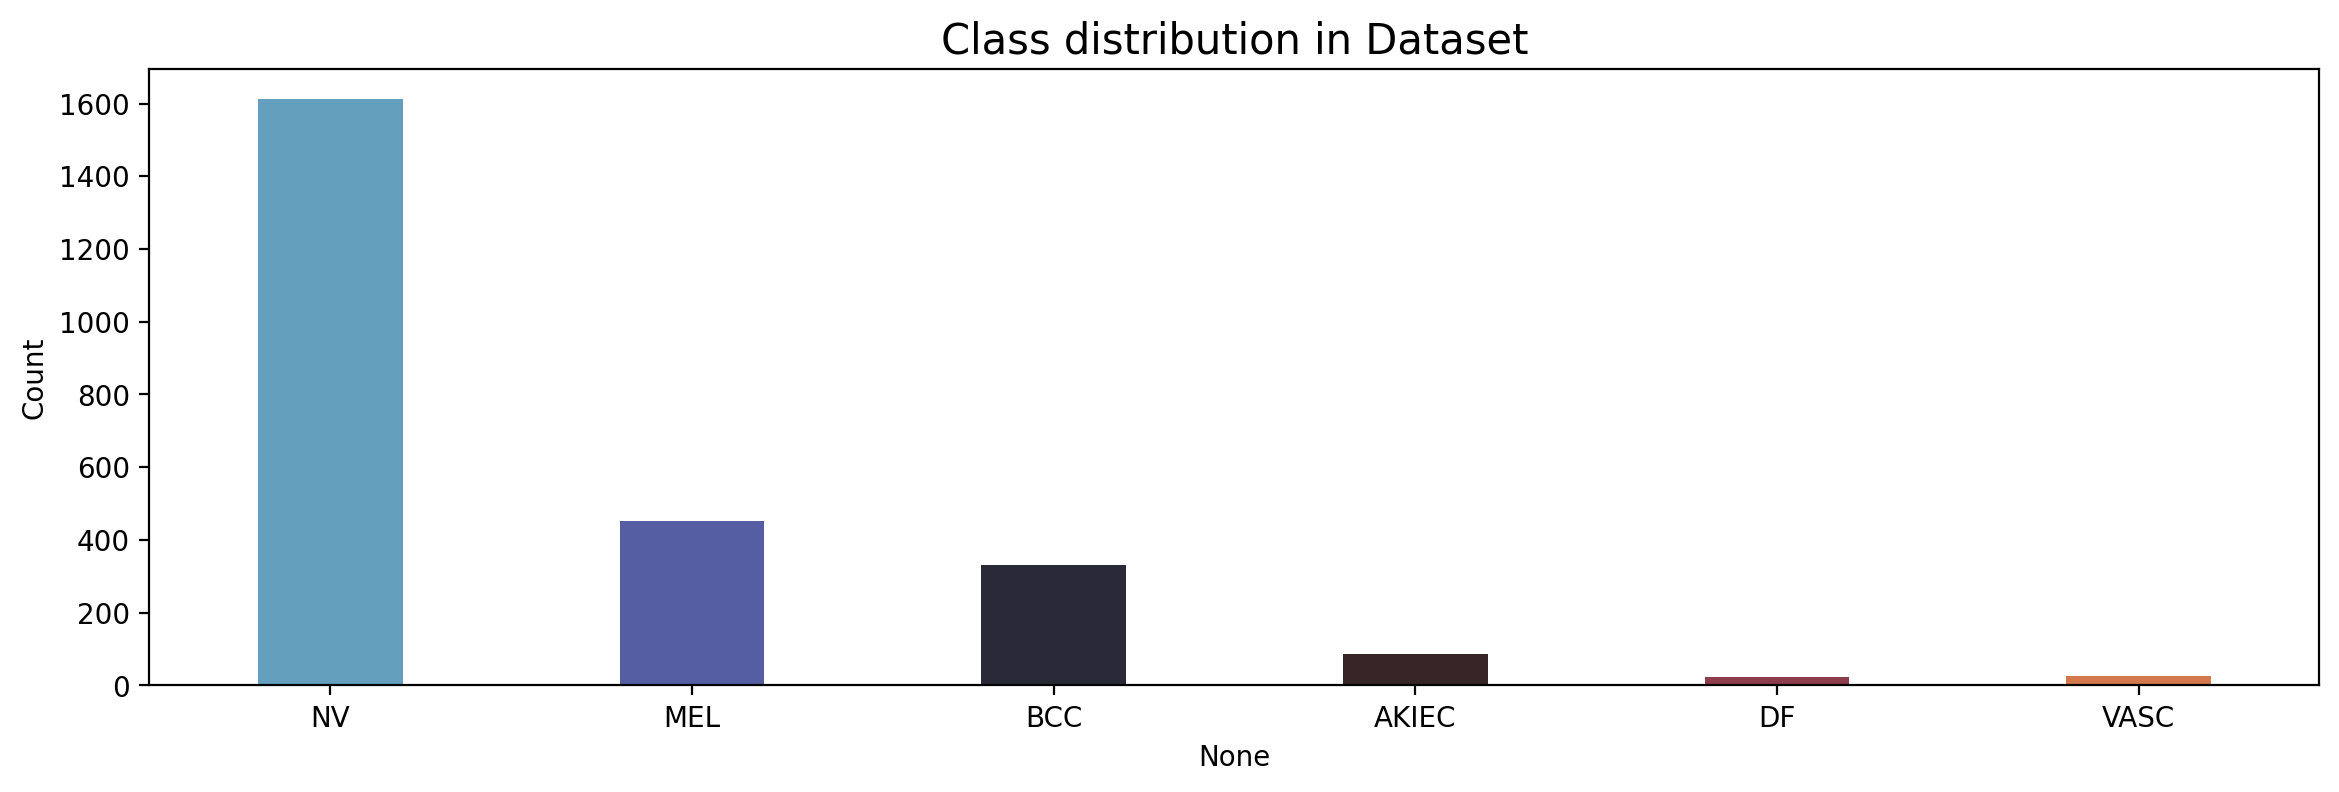

In [ ]:
# Visualization
label, count = np.unique(multiclass10percentdf.category, return_counts=True)
uni = pd.DataFrame(data=count, index=multiclass_categories.values(), columns=['Count'])

plt.figure(figsize=(14, 4), dpi=200)
sns.barplot(data=uni, x=uni.index, y='Count', palette='icefire', width=0.4).set_title('Class distribution in Dataset', fontsize=15)
plt.show()

In [ ]:
# Train-validation-test split
multiclass_train_df, multiclass_temp_df = train_test_split(multiclass10percentdf, test_size=0.2, stratify=multiclass10percentdf['category'], random_state=42)
multiclass_cv_df, multiclass_test_df = train_test_split(multiclass_temp_df, test_size=0.5, stratify=multiclass_temp_df['category'], random_state=42)


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/CS7643/project')
from utils import blurring, remove_hair
# from cv2 import GaussianBlur, medianBlur
import cv2

In [ ]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, blackhat_threshold, kernel_size_hair, kernel_size_blur, blur_func, doBlur, transform=None,):
        self.dataframe = dataframe
        self.transform = transform
        self.blackhat_threshold = blackhat_threshold
        self.kernel_size_tuple = (kernel_size_hair, kernel_size_hair)
        self.kernel_size_blur = kernel_size_blur
        self.blur_func = blur_func
        self.doBlur = doBlur

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        # image = Image.open(img_path).convert('RGB')
        image = cv2.imread(img_path)
        label = int(self.dataframe.iloc[idx, 1])
        cleaned_image = remove_hair(image, kernel_size_tuple=self.kernel_size_tuple, blackhat_threshold=self.blackhat_threshold)
        if(self.doBlur):
          cleaned_image = blurring(cleaned_image, kernel_size=self.kernel_size_blur,blur_func=self.blur_func)

        cleaned_image = Image.fromarray(cleaned_image)

        if self.transform:
            cleaned_image = self.transform(cleaned_image)

        return cleaned_image, label

image_size = (224, 224)
batch_size = 32

In [ ]:
# class SkinCancerDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.dataframe = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         img_path = self.dataframe.iloc[idx, 0]
#         image = Image.open(img_path).convert('RGB')
#         label = int(self.dataframe.iloc[idx, 1])
#         if self.transform:
#             image = self.transform(image)

#         return image, label

# image_size = (224, 224)
# batch_size = 32

In [ ]:

#####################################
# Transforms and Pre-Processing
#####################################
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Pre-processing
blackhat_threshold = 9
kernel_size_hair = 15
kernel_size_blur = 5
blur_func = cv2.GaussianBlur
doBlur = True

# Prepare dataset
train_dataset = SkinCancerDataset(multiclass_train_df, blackhat_threshold, kernel_size_hair, kernel_size_blur, blur_func, doBlur, transform=transform)
val_dataset = SkinCancerDataset(multiclass_cv_df, blackhat_threshold, kernel_size_hair, kernel_size_blur, blur_func, doBlur, transform=transform)
test_dataset = SkinCancerDataset(multiclass_test_df, blackhat_threshold, kernel_size_hair, kernel_size_blur, blur_func, doBlur, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=14)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=14)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=14)

In [ ]:
multiclass_train_df.shape

(2026, 2)

In [ ]:

# class EfficientNetB7(nn.Module):
#     def __init__(self, num_classes):
#         super(EfficientNetB7, self).__init__()
#         # Load pretrained EfficientNet B7
#         self.model = models.efficientnet_b7(weights=models.EfficientNet_B7_Weights.IMAGENET1K_V1)
#         # Get the number of input features for the classifier layer
#         in_features = self.model.classifier[1].in_features
#         # Replace the final classification layer
#         self.model.classifier[1] = nn.Linear(in_features, num_classes)
#         # Softmax for output probabilities
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         x = self.model(x)
#         x = self.softmax(x)
#         return x

# # Define the number of classes
# num_classes = len(multiclass_categories)  # Use your class count
# # Initialize the model
# model = EfficientNetB7(num_classes=num_classes)
# # Move the model to GPU if available
# model = model.cuda()

# # Check available GPUs
# [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]


In [ ]:
class EfficientNetB3(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB3, self).__init__()
        # Load pretrained EfficientNet B3
        self.model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        # Get the number of input features for the classifier layer
        in_features = self.model.classifier[1].in_features
        # Replace the final classification layer
        self.model.classifier[1] = nn.Linear(in_features, num_classes)
        # Softmax for output probabilities
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        return x

# Define the number of classes
num_classes = len(multiclass_categories)  # Use your class count
# Initialize the model
model = EfficientNetB3(num_classes=num_classes)
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Check available GPUs
print([torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 234MB/s]


['Tesla T4']


In [ ]:
def plot_curves(train_losses, val_losses, filename):
    '''
    '''
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='valid')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve - '+filename)
    plt.savefig(filename+'.png')
    plt.show()


In [ ]:
def get_best_val_loss(
    train_loader,
    val_loader,
    lr,
    weight_decay
):
    """
    Initializes and trains the EfficientNetB3 model with the given configuration.
    Returns the best validation loss.
    """
    # Configuration
    num_classes = len(multiclass_categories)  # Replace with your global variable
    class_weights = torch.tensor(list(multiclass_class_weights.values()), dtype=torch.float32)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    early_stopping_patience = 4

    # Initialize the EfficientNetB3 model
    model = EfficientNetB3(num_classes=num_classes)
    model = model.to(device)


    # Define the criterion with class weights
    class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Define the learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.4, patience=2)

    # Training parameters
    best_val_loss = float('inf')

    # Train the model using train_model function
    train_losses, train_accuracies, val_losses, val_accuracies, best_val_loss  = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=num_epochs,
        early_stopping_patience=early_stopping_patience,
        device=device,
        criterion=criterion
    )

    filename = f"RUN1_lr{lr}_wd{weight_decay}"
    plot_curves(train_accuracies, val_accuracies, filename)
    print(train_accuracies)
    print(val_accuracies)
    torch.cuda.empty_cache()

    return best_val_loss

In [ ]:
train_loader = DataLoader(train_dataset, 64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, 64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, 64, shuffle=False, num_workers=4)

# Initialize the EfficientNetB3 model
model = EfficientNetB3(num_classes=len(multiclass_categories))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the criterion with class weights
class_weights = torch.tensor(list(multiclass_class_weights.values()), dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=0)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.4, patience=2)

# Training parameters
num_epochs = 10
early_stopping_patience = 4
best_val_loss = float('inf')
epochs_no_improve = 0

print("EfficientNetB3 model initialized with training configuration.")


EfficientNetB3 model initialized with training configuration.


In [ ]:
# model = MobileNetV3(num_classes=len(multiclass_categories))
# device = torch.device("cuda")
# model = model.to(device)

# # Define the criterion with class weights
# class_weights = torch.tensor(list(multiclass_class_weights.values()), dtype=torch.float32).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
# optimizer = optim.Adam(model.parameters(), lr=3e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

# num_epochs = 2
# early_stopping_patience = 6
# best_val_loss = float('inf')
# epochs_no_improve = 0




In [ ]:
def train_one_epoch(epoch, model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0
    correct_train = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", ncols=100):
        images, labels = images.to(device, dtype=torch.float32), labels.cuda().long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / len(train_loader.dataset)

    return train_loss, train_accuracy

def validate_one_epoch(epoch, model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", ncols=100):
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / len(val_loader.dataset)

    return val_loss, val_accuracy

def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device, criterion):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(epoch, model, train_loader, optimizer, criterion, device)
        val_loss, val_accuracy = validate_one_epoch(epoch, model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies, best_val_loss

# train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device)
train_losses, train_accuracies, val_losses, val_accuracies, best_val_loss = train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, early_stopping_patience, device, criterion)

Validation Epoch 1/10: 100%|██████████████████████████████████████████| 4/4 [01:15<00:00, 18.99s/it]


Epoch 1/10, Train Loss: 1.5791, Train Accuracy: 0.5780, Validation Loss: 1.4122, Validation Accuracy: 0.6324


Validation Epoch 2/10: 100%|██████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch 2/10, Train Loss: 1.4003, Train Accuracy: 0.6451, Validation Loss: 1.3996, Validation Accuracy: 0.6364


Validation Epoch 3/10: 100%|██████████████████████████████████████████| 4/4 [00:06<00:00,  1.62s/it]


Epoch 3/10, Train Loss: 1.3778, Train Accuracy: 0.6644, Validation Loss: 1.3869, Validation Accuracy: 0.6522


Validation Epoch 4/10: 100%|██████████████████████████████████████████| 4/4 [00:06<00:00,  1.61s/it]


Epoch 4/10, Train Loss: 1.3432, Train Accuracy: 0.7043, Validation Loss: 1.3632, Validation Accuracy: 0.6838


Validation Epoch 5/10: 100%|██████████████████████████████████████████| 4/4 [00:06<00:00,  1.61s/it]


Epoch 5/10, Train Loss: 1.3097, Train Accuracy: 0.7419, Validation Loss: 1.3341, Validation Accuracy: 0.7154


Validation Epoch 6/10: 100%|██████████████████████████████████████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch 6/10, Train Loss: 1.2844, Train Accuracy: 0.7636, Validation Loss: 1.3004, Validation Accuracy: 0.7470


Validation Epoch 7/10: 100%|██████████████████████████████████████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 7/10, Train Loss: 1.2686, Train Accuracy: 0.7725, Validation Loss: 1.3084, Validation Accuracy: 0.7273


Validation Epoch 8/10: 100%|██████████████████████████████████████████| 4/4 [00:07<00:00,  1.75s/it]


Epoch 8/10, Train Loss: 1.2454, Train Accuracy: 0.7971, Validation Loss: 1.2940, Validation Accuracy: 0.7510


Validation Epoch 9/10: 100%|██████████████████████████████████████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch 9/10, Train Loss: 1.2439, Train Accuracy: 0.8026, Validation Loss: 1.3118, Validation Accuracy: 0.7273


Validation Epoch 10/10: 100%|█████████████████████████████████████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch 10/10, Train Loss: 1.2267, Train Accuracy: 0.8174, Validation Loss: 1.2964, Validation Accuracy: 0.7470


In [ ]:
print(multiclass_train_df.shape)
print(multiclass_cv_df.shape)
print(multiclass_test_df.shape)

(2026, 2)
(253, 2)
(254, 2)


Validation Epoch 1/7: 100%|███████████████████████████████████████████| 8/8 [00:07<00:00,  1.06it/s]


Epoch 1/7, Train Loss: 1.4963, Train Accuracy: 0.6194, Validation Loss: 1.3936, Validation Accuracy: 0.6522


Validation Epoch 2/7: 100%|███████████████████████████████████████████| 8/8 [00:07<00:00,  1.05it/s]


Epoch 2/7, Train Loss: 1.3733, Train Accuracy: 0.6693, Validation Loss: 1.3758, Validation Accuracy: 0.6759


Validation Epoch 3/7: 100%|███████████████████████████████████████████| 8/8 [00:07<00:00,  1.10it/s]


Epoch 3/7, Train Loss: 1.3186, Train Accuracy: 0.7315, Validation Loss: 1.3310, Validation Accuracy: 0.7154


Validation Epoch 4/7: 100%|███████████████████████████████████████████| 8/8 [00:07<00:00,  1.11it/s]


Epoch 4/7, Train Loss: 1.2817, Train Accuracy: 0.7626, Validation Loss: 1.2946, Validation Accuracy: 0.7549


Validation Epoch 5/7: 100%|███████████████████████████████████████████| 8/8 [00:07<00:00,  1.10it/s]


Epoch 5/7, Train Loss: 1.2681, Train Accuracy: 0.7784, Validation Loss: 1.3074, Validation Accuracy: 0.7391


Validation Epoch 6/7: 100%|███████████████████████████████████████████| 8/8 [00:07<00:00,  1.09it/s]


Epoch 6/7, Train Loss: 1.2539, Train Accuracy: 0.7907, Validation Loss: 1.3144, Validation Accuracy: 0.7312


Validation Epoch 7/7: 100%|███████████████████████████████████████████| 8/8 [00:07<00:00,  1.07it/s]


Epoch 7/7, Train Loss: 1.2562, Train Accuracy: 0.7863, Validation Loss: 1.3058, Validation Accuracy: 0.7431


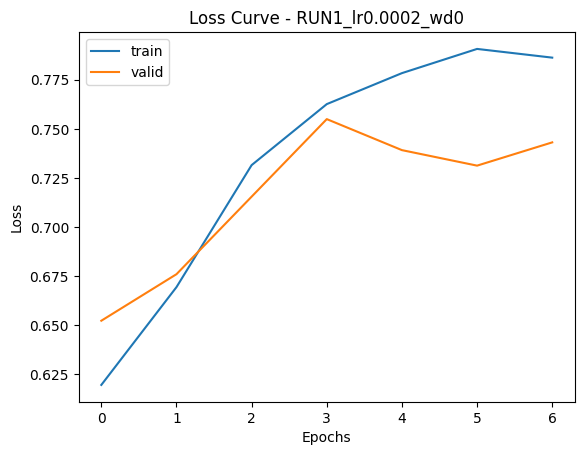

[0.6194471865745311, 0.6692991115498519, 0.7314906219151036, 0.7625863770977295, 0.778381046396841, 0.790720631786772, 0.7862783810463968]
[0.6521739130434783, 0.6758893280632411, 0.7154150197628458, 0.7549407114624506, 0.7391304347826086, 0.7312252964426877, 0.7430830039525692]


Validation Epoch 1/7: 100%|█████████████████████████████████████████| 32/32 [00:07<00:00,  4.45it/s]


Epoch 1/7, Train Loss: 1.4194, Train Accuracy: 0.6530, Validation Loss: 1.3228, Validation Accuracy: 0.7431


Validation Epoch 2/7: 100%|█████████████████████████████████████████| 32/32 [00:07<00:00,  4.50it/s]


Epoch 2/7, Train Loss: 1.3330, Train Accuracy: 0.7152, Validation Loss: 1.3205, Validation Accuracy: 0.7312


Validation Epoch 3/7: 100%|█████████████████████████████████████████| 32/32 [00:07<00:00,  4.44it/s]


Epoch 3/7, Train Loss: 1.3242, Train Accuracy: 0.7167, Validation Loss: 1.3159, Validation Accuracy: 0.7312


Validation Epoch 4/7: 100%|█████████████████████████████████████████| 32/32 [00:06<00:00,  4.67it/s]


Epoch 4/7, Train Loss: 1.3240, Train Accuracy: 0.7206, Validation Loss: 1.3327, Validation Accuracy: 0.7115


Validation Epoch 5/7: 100%|█████████████████████████████████████████| 32/32 [00:07<00:00,  4.46it/s]


Epoch 5/7, Train Loss: 1.3107, Train Accuracy: 0.7325, Validation Loss: 1.3077, Validation Accuracy: 0.7273


Validation Epoch 6/7: 100%|█████████████████████████████████████████| 32/32 [00:07<00:00,  4.51it/s]


Epoch 6/7, Train Loss: 1.3185, Train Accuracy: 0.7236, Validation Loss: 1.3117, Validation Accuracy: 0.7312


Validation Epoch 7/7: 100%|█████████████████████████████████████████| 32/32 [00:07<00:00,  4.43it/s]


Epoch 7/7, Train Loss: 1.2904, Train Accuracy: 0.7527, Validation Loss: 1.3184, Validation Accuracy: 0.7273


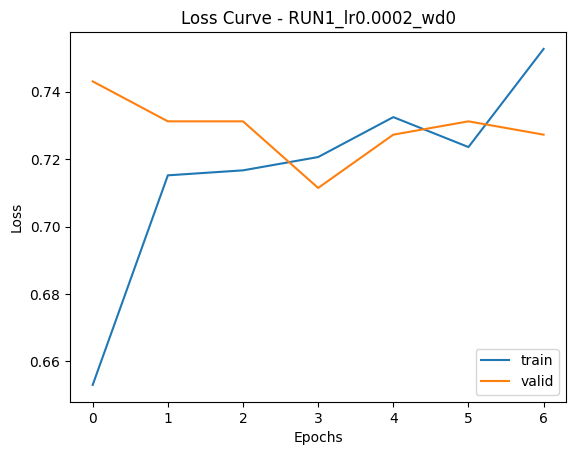

[0.6530108588351431, 0.7152023692003948, 0.7166831194471865, 0.7206317867719645, 0.7324777887462981, 0.7235932872655478, 0.7527147087857848]
[0.7430830039525692, 0.7312252964426877, 0.7312252964426877, 0.7114624505928854, 0.7272727272727273, 0.7312252964426877, 0.7272727272727273]


Training Epoch 1/7:  82%|█████████████████████████████████▌       | 104/127 [00:41<00:11,  2.07it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a77183a5d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Training Epoch 1/7:  83%|██████████████████████████████████▏      | 106/127 [00:42<00:06,  3.10it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a77183a5d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", li

Epoch 1/7, Train Loss: 1.4654, Train Accuracy: 0.6219, Validation Loss: 1.3699, Validation Accuracy: 0.6798


Validation Epoch 2/7: 100%|█████████████████████████████████████████| 16/16 [00:06<00:00,  2.43it/s]


Epoch 2/7, Train Loss: 1.3434, Train Accuracy: 0.7048, Validation Loss: 1.2889, Validation Accuracy: 0.7628


Validation Epoch 3/7: 100%|█████████████████████████████████████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 3/7, Train Loss: 1.3035, Train Accuracy: 0.7399, Validation Loss: 1.2812, Validation Accuracy: 0.7668


Validation Epoch 4/7: 100%|█████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 4/7, Train Loss: 1.2966, Train Accuracy: 0.7448, Validation Loss: 1.3240, Validation Accuracy: 0.7194


Validation Epoch 5/7: 100%|█████████████████████████████████████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 5/7, Train Loss: 1.2845, Train Accuracy: 0.7601, Validation Loss: 1.3149, Validation Accuracy: 0.7352


Validation Epoch 6/7: 100%|█████████████████████████████████████████| 16/16 [00:06<00:00,  2.29it/s]


Epoch 6/7, Train Loss: 1.2705, Train Accuracy: 0.7744, Validation Loss: 1.2869, Validation Accuracy: 0.7628


Validation Epoch 7/7: 100%|█████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


Epoch 7/7, Train Loss: 1.2659, Train Accuracy: 0.7794, Validation Loss: 1.2960, Validation Accuracy: 0.7470


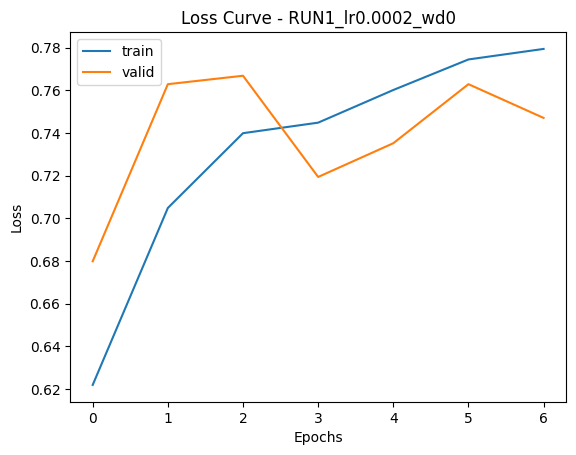

[0.6219151036525172, 0.7048371174728529, 0.7398815399802566, 0.7448173741362291, 0.7601184600197434, 0.7744323790720632, 0.7793682132280355]
[0.6798418972332015, 0.7628458498023716, 0.766798418972332, 0.7193675889328063, 0.7351778656126482, 0.7628458498023716, 0.7470355731225297]


Validation Epoch 1/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 1/7, Train Loss: 1.5734, Train Accuracy: 0.6002, Validation Loss: 1.4033, Validation Accuracy: 0.6640


Validation Epoch 2/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch 2/7, Train Loss: 1.3910, Train Accuracy: 0.6575, Validation Loss: 1.3723, Validation Accuracy: 0.6798


Validation Epoch 3/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.75s/it]


Epoch 3/7, Train Loss: 1.3409, Train Accuracy: 0.7108, Validation Loss: 1.3394, Validation Accuracy: 0.7115


Validation Epoch 4/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch 4/7, Train Loss: 1.2928, Train Accuracy: 0.7567, Validation Loss: 1.3016, Validation Accuracy: 0.7233


Validation Epoch 5/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch 5/7, Train Loss: 1.2614, Train Accuracy: 0.7883, Validation Loss: 1.2874, Validation Accuracy: 0.7628


Validation Epoch 6/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch 6/7, Train Loss: 1.2529, Train Accuracy: 0.7897, Validation Loss: 1.2792, Validation Accuracy: 0.7628


Validation Epoch 7/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 7/7, Train Loss: 1.2335, Train Accuracy: 0.8115, Validation Loss: 1.3025, Validation Accuracy: 0.7431


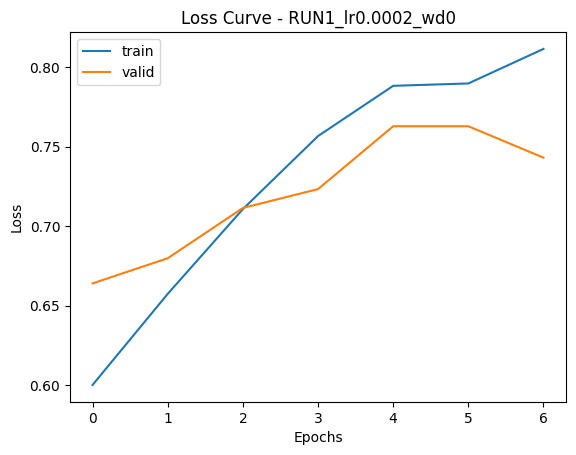

[0.6001974333662389, 0.6574531095755183, 0.7107601184600197, 0.7566633761105627, 0.7882527147087858, 0.7897334649555775, 0.8114511352418559]
[0.6640316205533597, 0.6798418972332015, 0.7114624505928854, 0.7233201581027668, 0.7628458498023716, 0.7628458498023716, 0.7430830039525692]
Best batch_size: 64 with val_loss: 1.279164949424653


Validation Epoch 1/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 1/7, Train Loss: 1.5719, Train Accuracy: 0.5884, Validation Loss: 1.4011, Validation Accuracy: 0.6522


Validation Epoch 2/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch 2/7, Train Loss: 1.3851, Train Accuracy: 0.6614, Validation Loss: 1.3667, Validation Accuracy: 0.6957


Validation Epoch 3/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 3/7, Train Loss: 1.3233, Train Accuracy: 0.7320, Validation Loss: 1.3281, Validation Accuracy: 0.7154


Validation Epoch 4/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 4/7, Train Loss: 1.2811, Train Accuracy: 0.7710, Validation Loss: 1.3275, Validation Accuracy: 0.7312


Validation Epoch 5/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 5/7, Train Loss: 1.2650, Train Accuracy: 0.7784, Validation Loss: 1.3266, Validation Accuracy: 0.7194


Validation Epoch 6/7: 100%|███████████████████████████████████████████| 4/4 [00:06<00:00,  1.74s/it]


Epoch 6/7, Train Loss: 1.2460, Train Accuracy: 0.8021, Validation Loss: 1.3006, Validation Accuracy: 0.7312


Validation Epoch 7/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 7/7, Train Loss: 1.2341, Train Accuracy: 0.8075, Validation Loss: 1.3074, Validation Accuracy: 0.7391


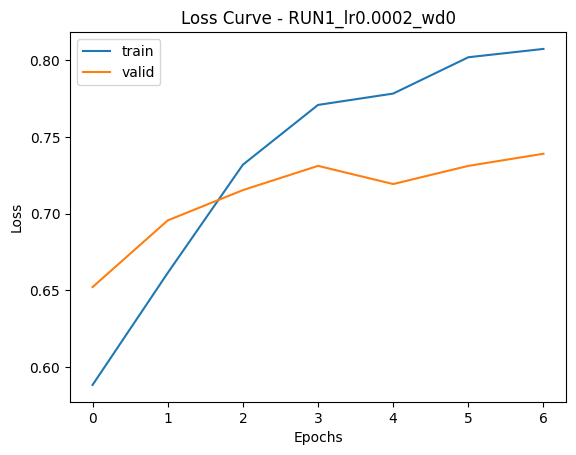

[0.5883514313919053, 0.6614017769002961, 0.7319842053307009, 0.7709772951628825, 0.778381046396841, 0.8020730503455084, 0.807502467917078]
[0.6521739130434783, 0.6956521739130435, 0.7154150197628458, 0.7312252964426877, 0.7193675889328063, 0.7312252964426877, 0.7391304347826086]


Validation Epoch 1/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 1/7, Train Loss: 1.6739, Train Accuracy: 0.5528, Validation Loss: 1.4988, Validation Accuracy: 0.6640


Validation Epoch 2/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch 2/7, Train Loss: 1.4486, Train Accuracy: 0.6481, Validation Loss: 1.4075, Validation Accuracy: 0.6443


Validation Epoch 3/7: 100%|███████████████████████████████████████████| 4/4 [00:06<00:00,  1.74s/it]


Epoch 3/7, Train Loss: 1.3941, Train Accuracy: 0.6550, Validation Loss: 1.3815, Validation Accuracy: 0.6719


Validation Epoch 4/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 4/7, Train Loss: 1.3661, Train Accuracy: 0.6851, Validation Loss: 1.3694, Validation Accuracy: 0.6838


Validation Epoch 5/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 5/7, Train Loss: 1.3357, Train Accuracy: 0.7162, Validation Loss: 1.3411, Validation Accuracy: 0.7036


Validation Epoch 6/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 6/7, Train Loss: 1.2974, Train Accuracy: 0.7596, Validation Loss: 1.3178, Validation Accuracy: 0.7312


Validation Epoch 7/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 7/7, Train Loss: 1.2671, Train Accuracy: 0.7878, Validation Loss: 1.3050, Validation Accuracy: 0.7589


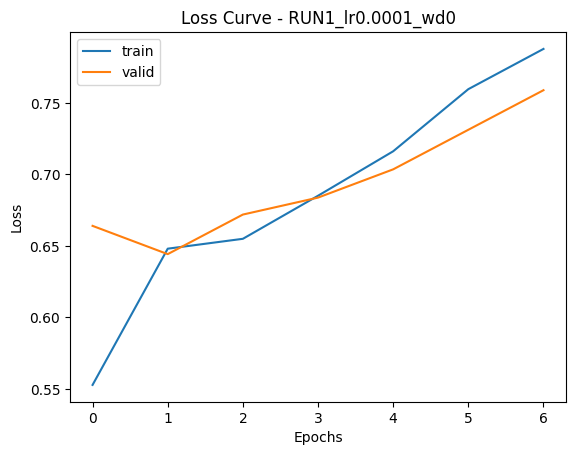

[0.5528134254689042, 0.6480750246791708, 0.6549851924975321, 0.6850937808489634, 0.7161895360315893, 0.7596248766041461, 0.7877591312931885]
[0.6640316205533597, 0.6442687747035574, 0.6719367588932806, 0.6837944664031621, 0.7035573122529645, 0.7312252964426877, 0.758893280632411]


Validation Epoch 1/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch 1/7, Train Loss: 1.4741, Train Accuracy: 0.6150, Validation Loss: 1.3773, Validation Accuracy: 0.6798


Validation Epoch 2/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.86s/it]


Epoch 2/7, Train Loss: 1.3348, Train Accuracy: 0.7162, Validation Loss: 1.3427, Validation Accuracy: 0.6996


Validation Epoch 3/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch 3/7, Train Loss: 1.3171, Train Accuracy: 0.7270, Validation Loss: 1.3232, Validation Accuracy: 0.7154


Validation Epoch 4/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch 4/7, Train Loss: 1.2937, Train Accuracy: 0.7493, Validation Loss: 1.3073, Validation Accuracy: 0.7352


Validation Epoch 5/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch 5/7, Train Loss: 1.2789, Train Accuracy: 0.7631, Validation Loss: 1.3155, Validation Accuracy: 0.7273


Validation Epoch 6/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch 6/7, Train Loss: 1.2845, Train Accuracy: 0.7577, Validation Loss: 1.3652, Validation Accuracy: 0.6680


Validation Epoch 7/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch 7/7, Train Loss: 1.2809, Train Accuracy: 0.7616, Validation Loss: 1.2971, Validation Accuracy: 0.7391


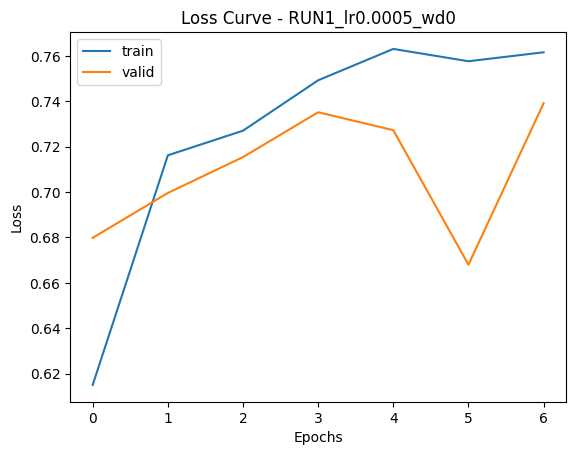

[0.6150049358341559, 0.7161895360315893, 0.7270483711747285, 0.7492596248766041, 0.7630799605133267, 0.7576505429417572, 0.7615992102665351]
[0.6798418972332015, 0.6996047430830039, 0.7154150197628458, 0.7351778656126482, 0.7272727272727273, 0.6679841897233202, 0.7391304347826086]


Validation Epoch 1/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch 1/7, Train Loss: 1.4342, Train Accuracy: 0.6402, Validation Loss: 1.3195, Validation Accuracy: 0.7233


Validation Epoch 2/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 2/7, Train Loss: 1.3474, Train Accuracy: 0.6940, Validation Loss: 1.3628, Validation Accuracy: 0.6798


Validation Epoch 3/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 3/7, Train Loss: 1.3313, Train Accuracy: 0.7098, Validation Loss: 1.3617, Validation Accuracy: 0.6838


Validation Epoch 4/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.85s/it]


Epoch 4/7, Train Loss: 1.3559, Train Accuracy: 0.6885, Validation Loss: 1.3641, Validation Accuracy: 0.6759


Validation Epoch 5/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch 5/7, Train Loss: 1.3327, Train Accuracy: 0.7098, Validation Loss: 1.3336, Validation Accuracy: 0.7075


Validation Epoch 6/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch 6/7, Train Loss: 1.3261, Train Accuracy: 0.7157, Validation Loss: 1.3143, Validation Accuracy: 0.7273


Validation Epoch 7/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch 7/7, Train Loss: 1.3176, Train Accuracy: 0.7226, Validation Loss: 1.3586, Validation Accuracy: 0.6838


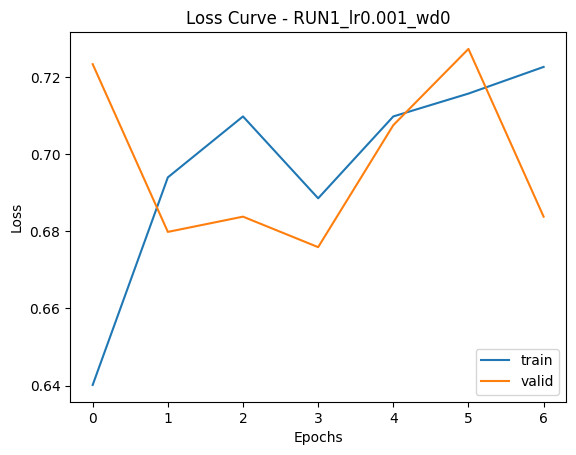

[0.640177690029615, 0.6939782823297137, 0.7097729516288253, 0.6885488647581441, 0.7097729516288253, 0.7156959526159921, 0.7226061204343535]
[0.7233201581027668, 0.6798418972332015, 0.6837944664031621, 0.6758893280632411, 0.7075098814229249, 0.7272727272727273, 0.6837944664031621]


Validation Epoch 1/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.86s/it]


Epoch 1/7, Train Loss: 1.4233, Train Accuracy: 0.6308, Validation Loss: 1.4093, Validation Accuracy: 0.6324


Validation Epoch 2/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 2/7, Train Loss: 1.4051, Train Accuracy: 0.6367, Validation Loss: 1.4124, Validation Accuracy: 0.6324


Validation Epoch 3/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch 3/7, Train Loss: 1.4093, Train Accuracy: 0.6338, Validation Loss: 1.3898, Validation Accuracy: 0.6482


Validation Epoch 4/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch 4/7, Train Loss: 1.4106, Train Accuracy: 0.6318, Validation Loss: 1.4756, Validation Accuracy: 0.5692


Validation Epoch 5/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch 5/7, Train Loss: 1.4158, Train Accuracy: 0.6278, Validation Loss: 1.4073, Validation Accuracy: 0.6364


Validation Epoch 6/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 6/7, Train Loss: 1.4094, Train Accuracy: 0.6343, Validation Loss: 1.4075, Validation Accuracy: 0.6364


Validation Epoch 7/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 7/7, Train Loss: 1.4069, Train Accuracy: 0.6367, Validation Loss: 1.4086, Validation Accuracy: 0.6364


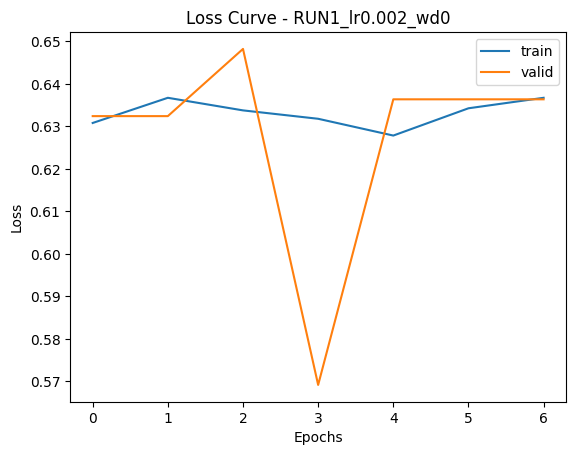

[0.6307996051332675, 0.6367226061204343, 0.633761105626851, 0.631786771964462, 0.6278381046396841, 0.6342546890424482, 0.6367226061204343]
[0.6324110671936759, 0.6324110671936759, 0.6482213438735178, 0.5691699604743083, 0.6363636363636364, 0.6363636363636364, 0.6363636363636364]
Best lr: 0.0002 with val_loss: 1.279164949424653


Validation Epoch 1/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch 1/7, Train Loss: 1.5651, Train Accuracy: 0.6051, Validation Loss: 1.4076, Validation Accuracy: 0.6640


Validation Epoch 2/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch 2/7, Train Loss: 1.3935, Train Accuracy: 0.6491, Validation Loss: 1.3847, Validation Accuracy: 0.6838


Validation Epoch 3/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 3/7, Train Loss: 1.3562, Train Accuracy: 0.6950, Validation Loss: 1.3483, Validation Accuracy: 0.7075


Validation Epoch 4/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 4/7, Train Loss: 1.2969, Train Accuracy: 0.7596, Validation Loss: 1.3009, Validation Accuracy: 0.7470


Validation Epoch 5/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch 5/7, Train Loss: 1.2702, Train Accuracy: 0.7808, Validation Loss: 1.3045, Validation Accuracy: 0.7431


Validation Epoch 6/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch 6/7, Train Loss: 1.2551, Train Accuracy: 0.7902, Validation Loss: 1.3307, Validation Accuracy: 0.7115


Validation Epoch 7/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch 7/7, Train Loss: 1.2408, Train Accuracy: 0.8055, Validation Loss: 1.3155, Validation Accuracy: 0.7233


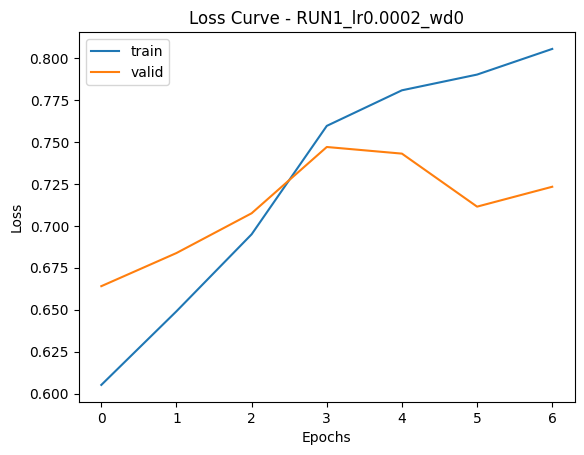

[0.6051332675222113, 0.6490621915103653, 0.6949654491609082, 0.7596248766041461, 0.7808489634748272, 0.7902270483711747, 0.805528134254689]
[0.6640316205533597, 0.6837944664031621, 0.7075098814229249, 0.7470355731225297, 0.7430830039525692, 0.7114624505928854, 0.7233201581027668]


Validation Epoch 1/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 1/7, Train Loss: 1.5715, Train Accuracy: 0.5913, Validation Loss: 1.4213, Validation Accuracy: 0.6403


Validation Epoch 2/7: 100%|███████████████████████████████████████████| 4/4 [00:06<00:00,  1.75s/it]


Epoch 2/7, Train Loss: 1.3946, Train Accuracy: 0.6535, Validation Loss: 1.3791, Validation Accuracy: 0.6877


Validation Epoch 3/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch 3/7, Train Loss: 1.3364, Train Accuracy: 0.7142, Validation Loss: 1.3582, Validation Accuracy: 0.6917


Validation Epoch 4/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch 4/7, Train Loss: 1.2792, Train Accuracy: 0.7700, Validation Loss: 1.3044, Validation Accuracy: 0.7391


Validation Epoch 5/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 5/7, Train Loss: 1.2637, Train Accuracy: 0.7823, Validation Loss: 1.3441, Validation Accuracy: 0.6957


Validation Epoch 6/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.86s/it]


Epoch 6/7, Train Loss: 1.2411, Train Accuracy: 0.8060, Validation Loss: 1.3286, Validation Accuracy: 0.7036


Validation Epoch 7/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch 7/7, Train Loss: 1.2429, Train Accuracy: 0.8016, Validation Loss: 1.2972, Validation Accuracy: 0.7510


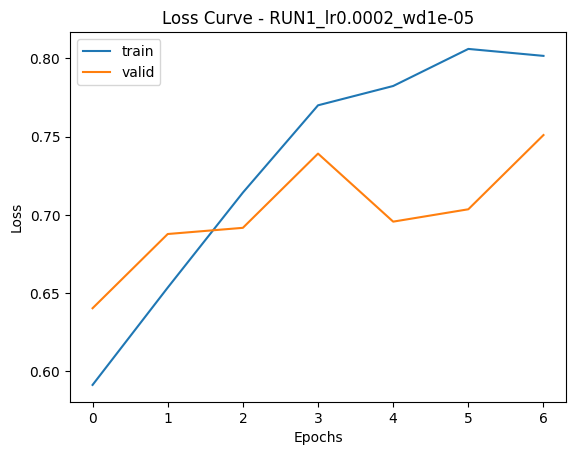

[0.5913129318854886, 0.6535044422507403, 0.7142152023692004, 0.769990128331688, 0.782329713721619, 0.8060217176702863, 0.8015794669299111]
[0.6403162055335968, 0.6877470355731226, 0.691699604743083, 0.7391304347826086, 0.6956521739130435, 0.7035573122529645, 0.7509881422924901]


Validation Epoch 1/7: 100%|███████████████████████████████████████████| 4/4 [00:06<00:00,  1.73s/it]


Epoch 1/7, Train Loss: 1.5599, Train Accuracy: 0.6140, Validation Loss: 1.4149, Validation Accuracy: 0.6482


Validation Epoch 2/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 2/7, Train Loss: 1.3930, Train Accuracy: 0.6584, Validation Loss: 1.3840, Validation Accuracy: 0.6838


Validation Epoch 3/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 3/7, Train Loss: 1.3487, Train Accuracy: 0.7093, Validation Loss: 1.3251, Validation Accuracy: 0.7391


Validation Epoch 4/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch 4/7, Train Loss: 1.2883, Train Accuracy: 0.7626, Validation Loss: 1.2995, Validation Accuracy: 0.7312


Validation Epoch 5/7: 100%|███████████████████████████████████████████| 4/4 [00:06<00:00,  1.75s/it]


Epoch 5/7, Train Loss: 1.2555, Train Accuracy: 0.7957, Validation Loss: 1.3246, Validation Accuracy: 0.7115


Validation Epoch 6/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch 6/7, Train Loss: 1.2538, Train Accuracy: 0.7878, Validation Loss: 1.3178, Validation Accuracy: 0.7194


Validation Epoch 7/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 7/7, Train Loss: 1.2242, Train Accuracy: 0.8248, Validation Loss: 1.3222, Validation Accuracy: 0.7115


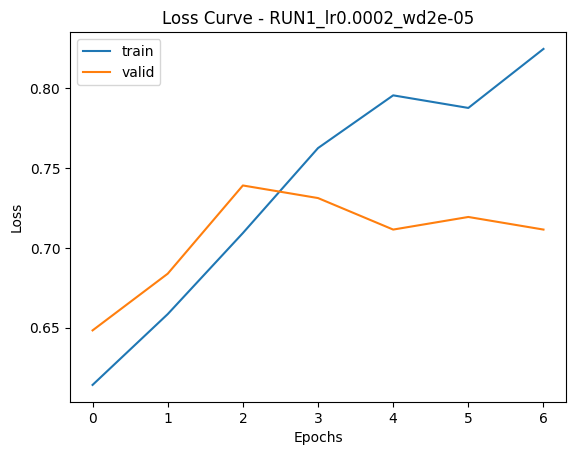

[0.6140177690029615, 0.6584402764067128, 0.709279368213228, 0.7625863770977295, 0.7956564659427443, 0.7877591312931885, 0.8247778874629812]
[0.6482213438735178, 0.6837944664031621, 0.7391304347826086, 0.7312252964426877, 0.7114624505928854, 0.7193675889328063, 0.7114624505928854]


Validation Epoch 1/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 1/7, Train Loss: 1.5626, Train Accuracy: 0.5992, Validation Loss: 1.4155, Validation Accuracy: 0.6759


Validation Epoch 2/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 2/7, Train Loss: 1.3906, Train Accuracy: 0.6614, Validation Loss: 1.3739, Validation Accuracy: 0.6838


Validation Epoch 3/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 3/7, Train Loss: 1.3400, Train Accuracy: 0.7266, Validation Loss: 1.3228, Validation Accuracy: 0.7273


Validation Epoch 4/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch 4/7, Train Loss: 1.2860, Train Accuracy: 0.7636, Validation Loss: 1.3208, Validation Accuracy: 0.7154


Validation Epoch 5/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 5/7, Train Loss: 1.2674, Train Accuracy: 0.7784, Validation Loss: 1.3179, Validation Accuracy: 0.7273


Validation Epoch 6/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch 6/7, Train Loss: 1.2566, Train Accuracy: 0.7878, Validation Loss: 1.2942, Validation Accuracy: 0.7549


Validation Epoch 7/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch 7/7, Train Loss: 1.2382, Train Accuracy: 0.8070, Validation Loss: 1.2964, Validation Accuracy: 0.7470


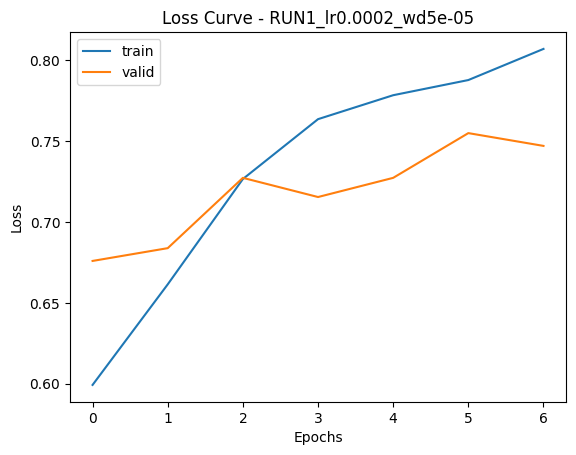

[0.5992102665350444, 0.6614017769002961, 0.7265547877591313, 0.763573543928924, 0.778381046396841, 0.7877591312931885, 0.8070088845014808]
[0.6758893280632411, 0.6837944664031621, 0.7272727272727273, 0.7154150197628458, 0.7272727272727273, 0.7549407114624506, 0.7470355731225297]


Validation Epoch 1/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch 1/7, Train Loss: 1.5676, Train Accuracy: 0.5997, Validation Loss: 1.4105, Validation Accuracy: 0.6719


Validation Epoch 2/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 2/7, Train Loss: 1.3834, Train Accuracy: 0.6723, Validation Loss: 1.3750, Validation Accuracy: 0.6957


Validation Epoch 3/7: 100%|███████████████████████████████████████████| 4/4 [00:06<00:00,  1.72s/it]


Epoch 3/7, Train Loss: 1.3296, Train Accuracy: 0.7290, Validation Loss: 1.3219, Validation Accuracy: 0.7352


Validation Epoch 4/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch 4/7, Train Loss: 1.2895, Train Accuracy: 0.7586, Validation Loss: 1.3282, Validation Accuracy: 0.7154


Validation Epoch 5/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch 5/7, Train Loss: 1.2702, Train Accuracy: 0.7725, Validation Loss: 1.3028, Validation Accuracy: 0.7510


Validation Epoch 6/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 6/7, Train Loss: 1.2443, Train Accuracy: 0.8040, Validation Loss: 1.3255, Validation Accuracy: 0.7075


Validation Epoch 7/7: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch 7/7, Train Loss: 1.2348, Train Accuracy: 0.8134, Validation Loss: 1.3051, Validation Accuracy: 0.7312


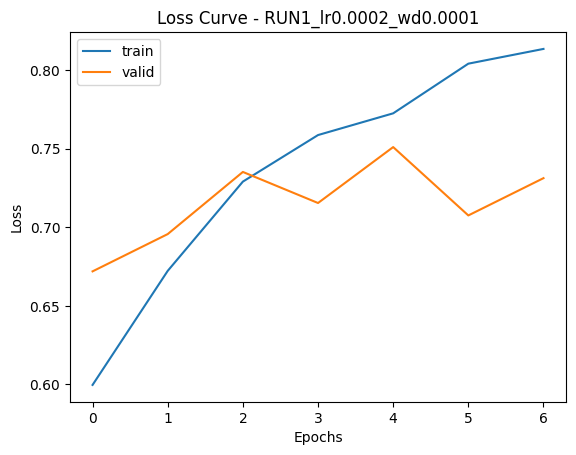

[0.5997038499506416, 0.6722606120434353, 0.7290227048371175, 0.7586377097729516, 0.7724580454096742, 0.8040473840078973, 0.8134254689042448]
[0.6719367588932806, 0.6956521739130435, 0.7351778656126482, 0.7154150197628458, 0.7509881422924901, 0.7075098814229249, 0.7312252964426877]
Best weight_decay: 0 with val_loss: 1.279164949424653
Final best parameters: {'batch_size': 64, 'lr': 0.0002, 'weight_decay': 0}


In [ ]:
#####################################################
# HYPERPARAM TUNING
#####################################################

batch_size1 = [32, 8, 16, 64]
lr1 = [2e-4, 1e-4, 5e-4, 1e-3, 2e-3]
weight_decay = [0, 1e-5, 2e-5, 5e-5, 1e-4]

# Pre-processing
# blackhat_threshold = [5, 9, 12, 15]
# kernel_size_hair = [5, 10, 15, 20]
# kernel_size_blur = [3, 5, 10, 15]
# blur_func = cv2.GaussianBlur
# doBlur = True

# blackhat_threshold = 9
# kernel_size_hair = 15
# kernel_size_blur = 5
# blur_func = cv2.GaussianBlur
# doBlur = True

num_epochs = 7


best_param = {
    "batch_size": batch_size1[0],
    "lr": lr1[0],
    "weight_decay": weight_decay[0]
}



min_val_loss = float('inf')

tuning_order = [
    ("batch_size", batch_size1),
    ("lr", lr1),
    ("weight_decay", weight_decay)]


for param_name, param_values in tuning_order:
    for value in param_values:
      curr_batch_size = best_param["batch_size"] if param_name != "batch_size" else value
      curr_lr = best_param["lr"] if param_name != "lr" else value
      curr_weight_decay = best_param["weight_decay"] if param_name != "weight_decay" else value

      train_loader = DataLoader(train_dataset, curr_batch_size, shuffle=True, num_workers=4)
      val_loader = DataLoader(val_dataset, curr_batch_size, shuffle=False, num_workers=4)
      test_loader = DataLoader(test_dataset, curr_batch_size, shuffle=False, num_workers=4)

      # Compute the best validation loss
      best_val_loss = get_best_val_loss(
          train_loader=train_loader,
          val_loader=val_loader,
          lr=curr_lr,
          weight_decay=curr_weight_decay
      )

      file_path = '/content/drive/MyDrive/CS7643/project/BASELINET0.txt'
      data = f"bs{curr_batch_size}_lr{curr_lr}_wd{curr_weight_decay}: val_loss{best_val_loss}\n"
      with open(file_path, 'a') as file:
        file.write(data)

      if best_val_loss < min_val_loss:
          min_val_loss = best_val_loss
          best_param[param_name] = value

    print(f"Best {param_name}: {best_param[param_name]} with val_loss: {min_val_loss}")

print("Final best parameters:", best_param)

Validation Epoch 1/1: 100%|███████████████████████████████████████████| 8/8 [01:19<00:00,  9.97s/it]


Epoch 1/1, Train Loss: 1.4974, Train Accuracy: 0.6165, Validation Loss: 1.3901, Validation Accuracy: 0.6719


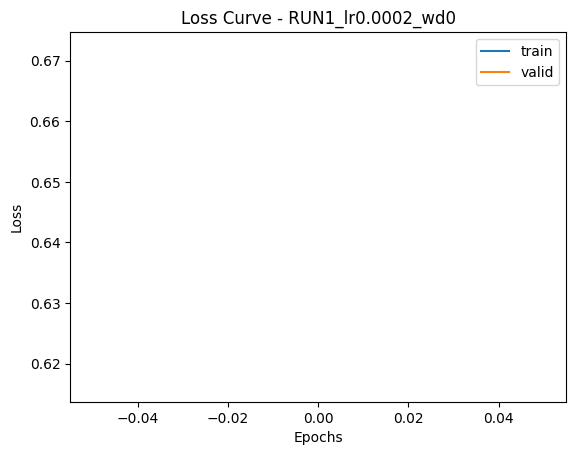

Validation Epoch 1/1: 100%|█████████████████████████████████████████| 32/32 [00:07<00:00,  4.36it/s]


Epoch 1/1, Train Loss: 1.4292, Train Accuracy: 0.6397, Validation Loss: 1.3951, Validation Accuracy: 0.6482


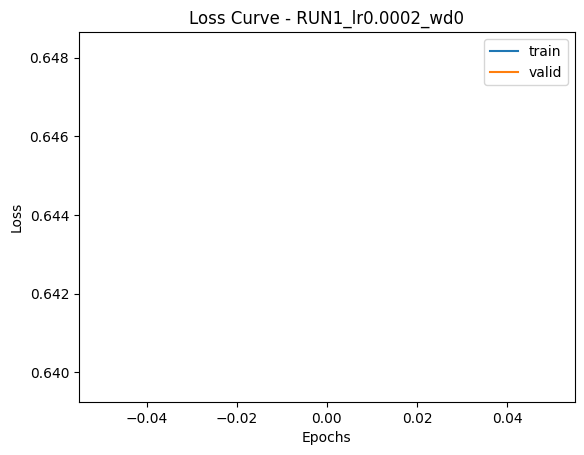

Validation Epoch 1/1: 100%|█████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


Epoch 1/1, Train Loss: 1.4504, Train Accuracy: 0.6352, Validation Loss: 1.3589, Validation Accuracy: 0.6996


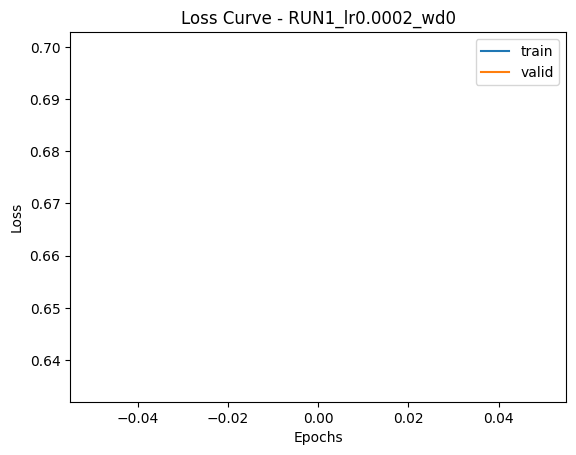

Validation Epoch 1/1: 100%|███████████████████████████████████████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 1/1, Train Loss: 1.5995, Train Accuracy: 0.5523, Validation Loss: 1.4130, Validation Accuracy: 0.6640


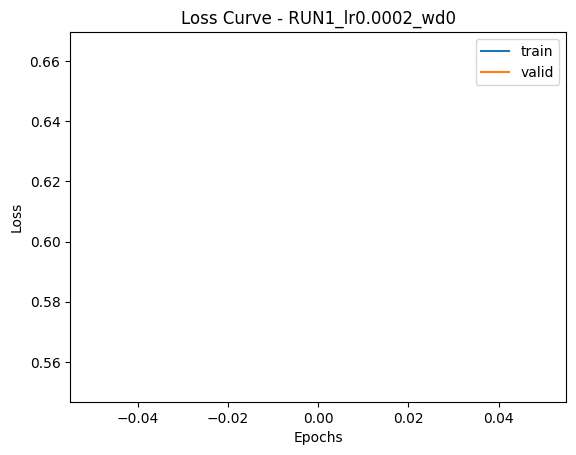

Best batch_size: 16 with val_loss: 1.3589045407743794


Validation Epoch 1/1: 100%|█████████████████████████████████████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch 1/1, Train Loss: 1.4562, Train Accuracy: 0.6422, Validation Loss: 1.3696, Validation Accuracy: 0.6838


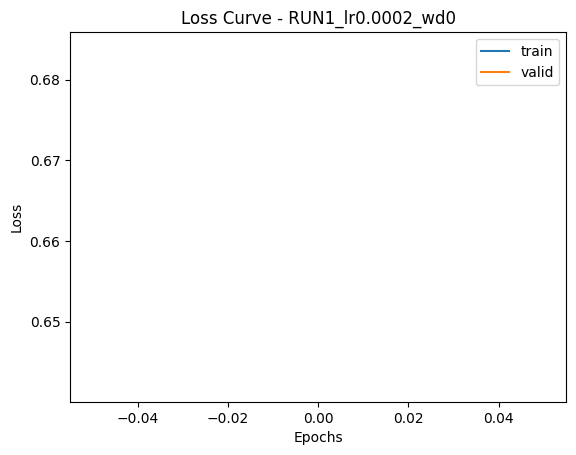

Validation Epoch 1/1: 100%|█████████████████████████████████████████| 16/16 [00:07<00:00,  2.17it/s]


Epoch 1/1, Train Loss: 1.5186, Train Accuracy: 0.6032, Validation Loss: 1.4024, Validation Accuracy: 0.6798


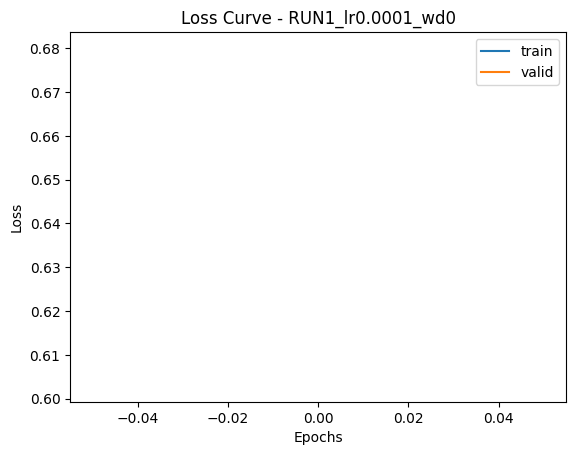

Validation Epoch 1/1: 100%|█████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


Epoch 1/1, Train Loss: 1.4158, Train Accuracy: 0.6486, Validation Loss: 1.4261, Validation Accuracy: 0.6047


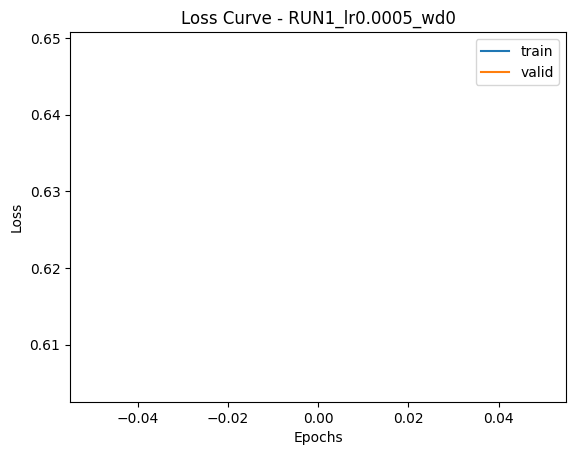

Validation Epoch 1/1: 100%|█████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 1/1, Train Loss: 1.3985, Train Accuracy: 0.6540, Validation Loss: 1.3908, Validation Accuracy: 0.6522


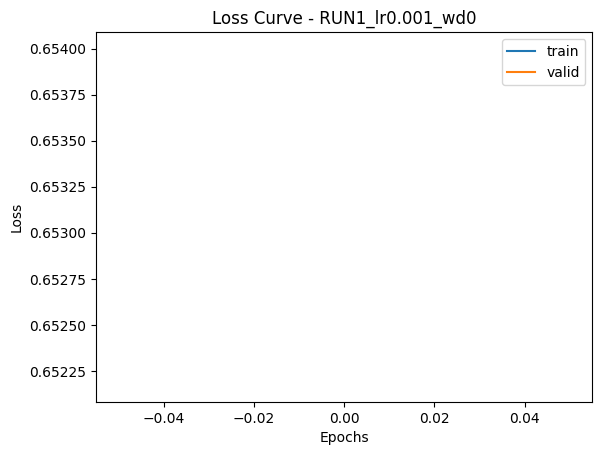

Validation Epoch 1/1: 100%|█████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


Epoch 1/1, Train Loss: 1.4293, Train Accuracy: 0.6130, Validation Loss: 1.4076, Validation Accuracy: 0.6364


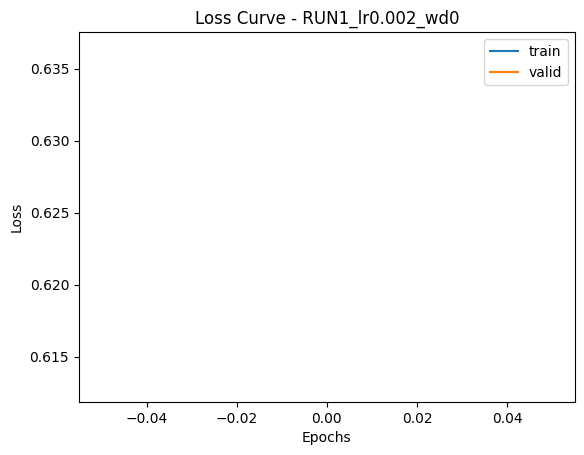

Best lr: 0.0002 with val_loss: 1.3589045407743794


Validation Epoch 1/1: 100%|█████████████████████████████████████████| 16/16 [00:07<00:00,  2.21it/s]


Epoch 1/1, Train Loss: 1.4549, Train Accuracy: 0.6347, Validation Loss: 1.3543, Validation Accuracy: 0.7273


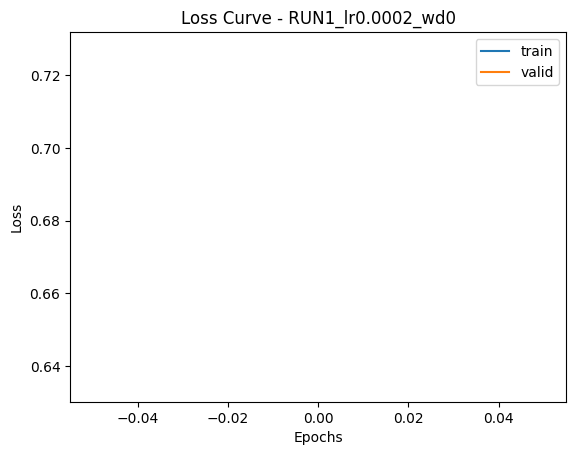

Validation Epoch 1/1: 100%|█████████████████████████████████████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch 1/1, Train Loss: 1.4563, Train Accuracy: 0.6323, Validation Loss: 1.3708, Validation Accuracy: 0.6957


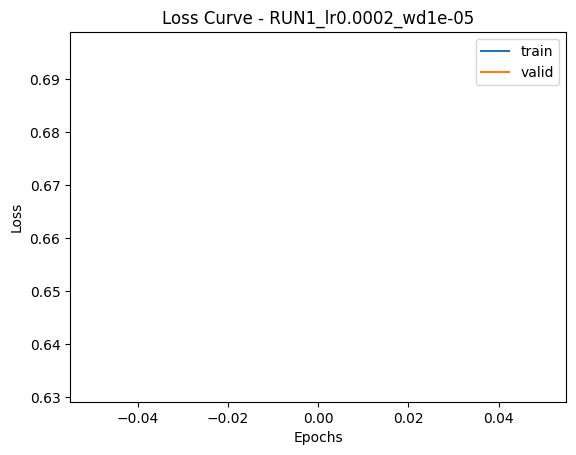

Validation Epoch 1/1: 100%|█████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 1/1, Train Loss: 1.4580, Train Accuracy: 0.6283, Validation Loss: 1.3763, Validation Accuracy: 0.6601


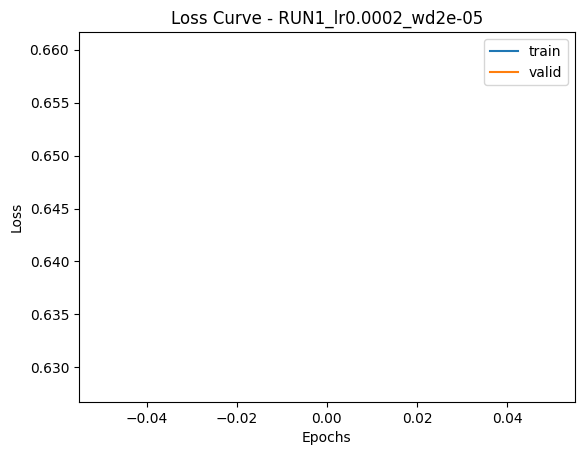

Validation Epoch 1/1: 100%|█████████████████████████████████████████| 16/16 [00:07<00:00,  2.16it/s]


Epoch 1/1, Train Loss: 1.4610, Train Accuracy: 0.6278, Validation Loss: 1.3614, Validation Accuracy: 0.6996


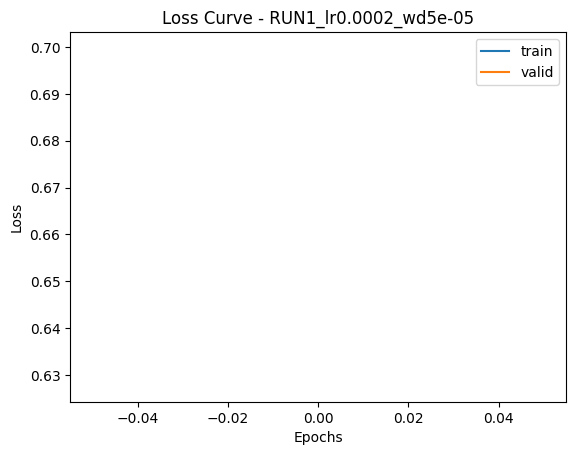

Validation Epoch 1/1: 100%|█████████████████████████████████████████| 16/16 [00:07<00:00,  2.21it/s]


Epoch 1/1, Train Loss: 1.4646, Train Accuracy: 0.6190, Validation Loss: 1.3776, Validation Accuracy: 0.6601


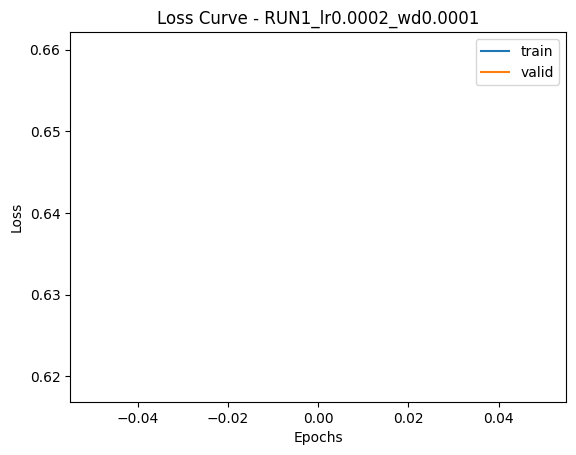

Best weight_decay: 0 with val_loss: 1.3542688915380847
Final best parameters: {'batch_size': 16, 'lr': 0.0002, 'weight_decay': 0}


In [ ]:
#####################################################
# HYPERPARAM TUNING
#####################################################

# batch_size1 = [32, 8, 16, 64]
# lr1 = [2e-4, 1e-4, 5e-4, 1e-3, 2e-3]
# weight_decay = [0, 1e-5, 2e-5, 5e-5, 1e-4]

# # Pre-processing
# # blackhat_threshold = [5, 9, 12, 15]
# # kernel_size_hair = [5, 10, 15, 20]
# # kernel_size_blur = [3, 5, 10, 15]
# # blur_func = cv2.GaussianBlur
# # doBlur = True

# # blackhat_threshold = 9
# # kernel_size_hair = 15
# # kernel_size_blur = 5
# # blur_func = cv2.GaussianBlur
# # doBlur = True

# num_epochs = 1


# best_param = {
#     "batch_size": batch_size1[0],
#     "lr": lr1[0],
#     "weight_decay": weight_decay[0]
# }

# min_val_loss = float('inf')

# tuning_order = [
#     ("batch_size", batch_size1),
#     ("lr", lr1),
#     ("weight_decay", weight_decay)]


# for param_name, param_values in tuning_order:
#     for value in param_values:

#         if param_name == "batch_size":
#             train_loader = DataLoader(train_dataset, batch_size=value, shuffle=True, num_workers=4)
#             val_loader = DataLoader(val_dataset, batch_size=value, shuffle=False, num_workers=4)
#             test_loader = DataLoader(test_dataset, batch_size=value, shuffle=False, num_workers=4)
#         else:
#             train_loader = DataLoader(train_dataset, batch_size=best_param["batch_size"], shuffle=True, num_workers=4)
#             val_loader = DataLoader(val_dataset, batch_size=best_param["batch_size"], shuffle=False, num_workers=4)
#             test_loader = DataLoader(test_dataset, batch_size=best_param["batch_size"], shuffle=False, num_workers=4)

#         # Compute the best validation loss
#         best_val_loss = get_best_val_loss(
#             train_loader=train_loader,
#             val_loader=val_loader,
#             lr=best_param["lr"] if param_name != "lr" else value,
#             weight_decay=best_param["weight_decay"] if param_name != "weight_decay" else value,
#         )

#         file_path = '/content/drive/MyDrive/CS7643/project/BASELINET0.txt'
#         data = f"bs{batch_size1}_lr{lr1}_wd{weight_decay}: val_loss{best_val_loss}\n"
#         with open(file_path, 'a') as file:
#           file.write(data)

#         if best_val_loss < min_val_loss:
#             min_val_loss = best_val_loss
#             best_param[param_name] = value

#     print(f"Best {param_name}: {best_param[param_name]} with val_loss: {min_val_loss}")

# print("Final best parameters:", best_param)

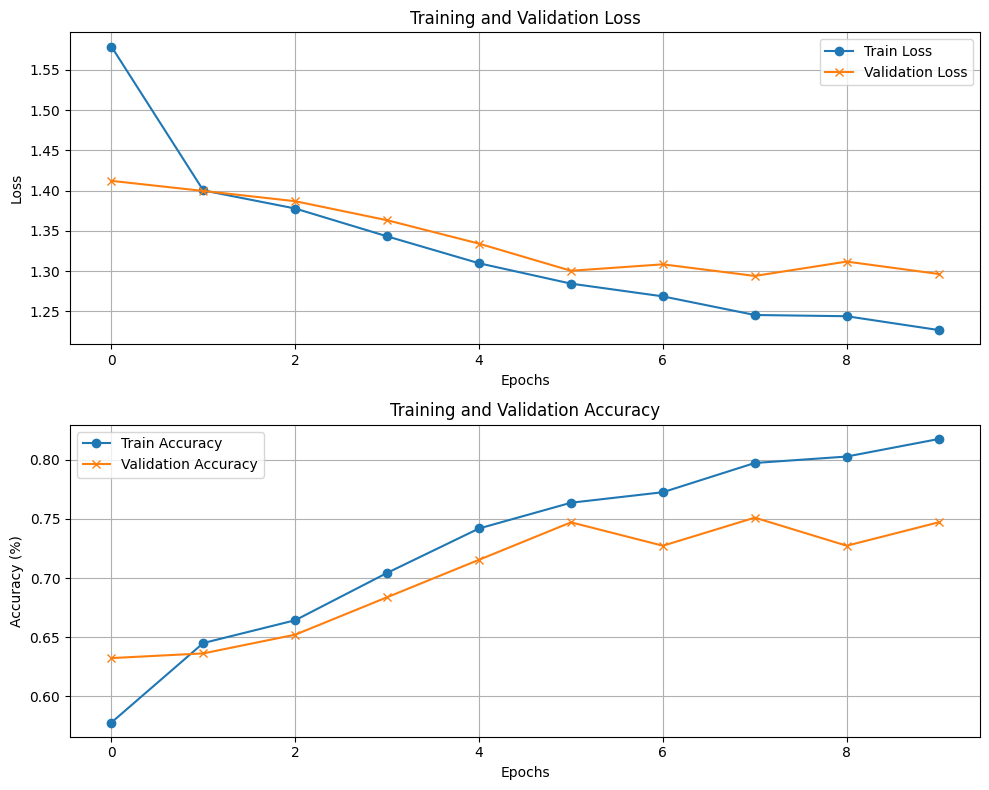

In [ ]:
plt.figure(figsize=(10, 8))

# Plot losses
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot accuracies
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()




In [ ]:
pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 101.6 MB/s eta 0:00:00


In [ ]:
# Test the model
model.eval()
test_loss = 0.0
correct_test = 0

# Create a dummy input tensor matching the input dimensions of the model
dummy_input = torch.randn(1, 3, 224, 224, device='cuda')  # Example for a model with 3-channel image input

# Export the model
torch.onnx.export(model, dummy_input, "model.onnx", export_params=True, opset_version=10)

predictions = []
true_classes = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing", ncols=100):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_classes.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct_test / len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Testing: 100%|████████████████████████████████████████████████████████| 4/4 [01:25<00:00, 21.37s/it]

Test Loss: 1.2877
Test Accuracy: 75.59%


In [ ]:
# Calculate precision
precision = accuracy_score(true_classes, predictions) * 100
print(f'Precision: {precision:.2f}%')


Precision: 75.59%


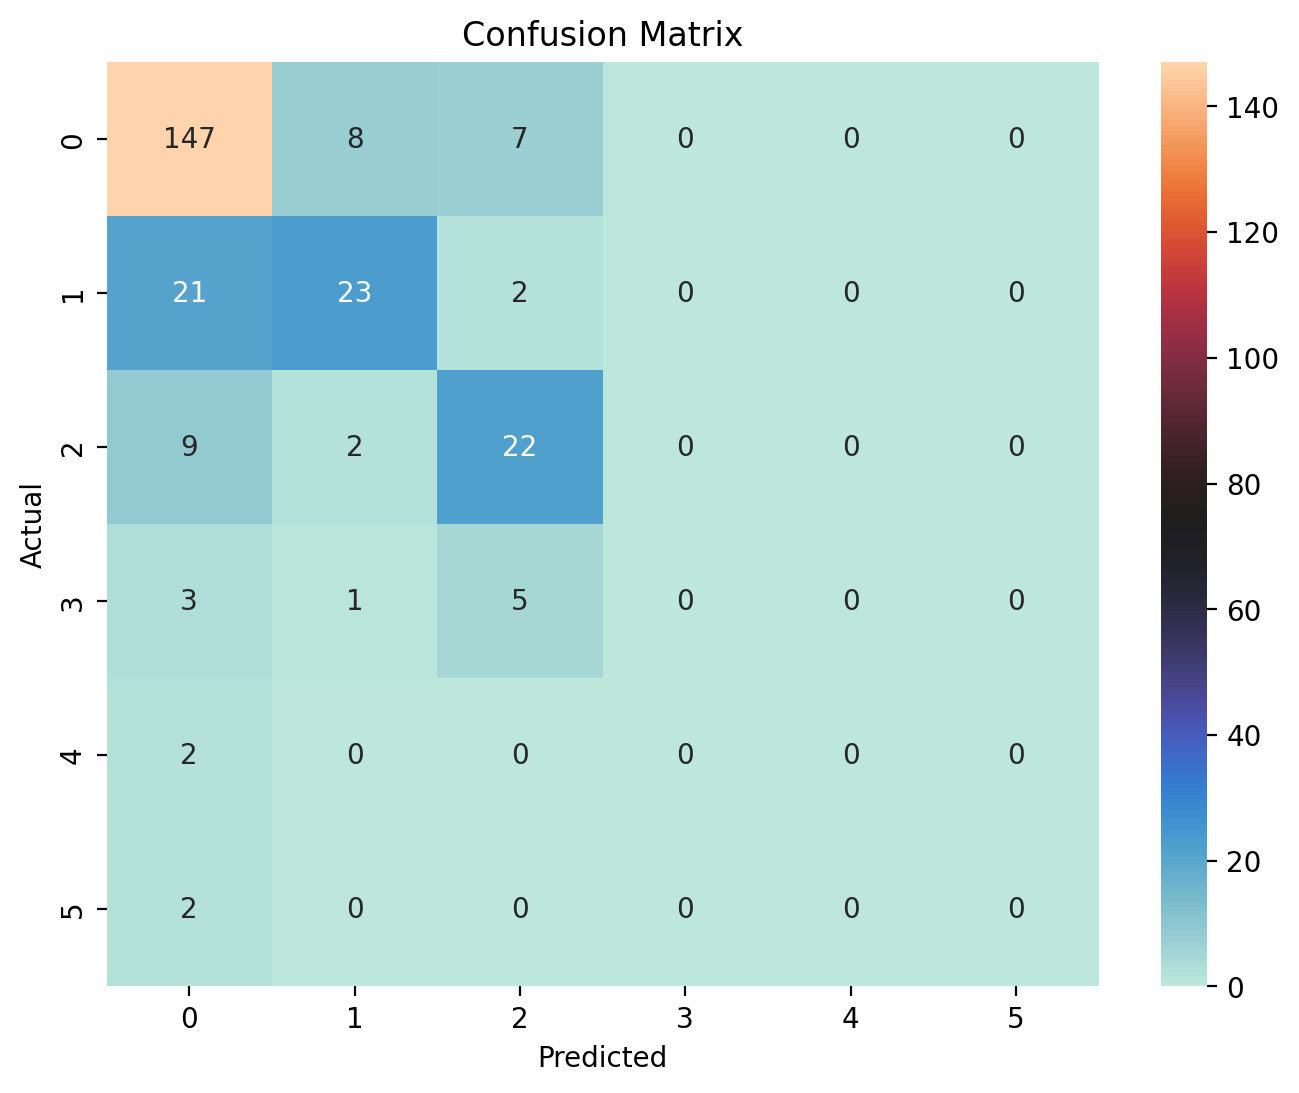

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predictions)
plt.figure(figsize=(8, 6), dpi=200)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='icefire', xticklabels=multiclass_categories.keys(), yticklabels=multiclass_categories.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()


In [ ]:
# Save the model
torch.save(model.state_dict(), 'multiclass_model_final.pth')

# Load an image-label pair from the test dataset
image, label = test_dataset.__getitem__(0)
print(image)

# Ensure the model is in evaluation mode
model.eval()

# If you're using a GPU, you also need to send the image and the model to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
image = image.to(device)  # Send the image to the GPU if you're using one

# Perform the forward pass with no_grad to save memory and compute speed
with torch.no_grad():
    output = model(image.unsqueeze(0))  # Add a batch dimension

# Print the output
print("output: ", output)

# To get the predicted class
predicted_class = torch.argmax(output)
print(f"Predicted class: {predicted_class}")

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [ ]:

# https://arxiv.org/abs/2103.03230
# Encoder network (example)
class Encoder(nn.Module):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        # self.fc = nn.Linear(input_dim, embedding_dim)
        self.model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.feature_extractor = self.model.features  # Correct reference
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # GAP to get fixed-size features
        self.fc = nn.Linear(2560, embedding_dim)  # Map to embedding_dim if needed

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract features
        x = self.global_avg_pool(x)   # Apply GAP -> [batch_size, 2560, 1, 1]
        x = torch.flatten(x, 1)       # Flatten to [batch_size, 2560]
        x = self.fc(x)                # Map to embedding dimension if required
        return x

    model = model.cuda()


# Function to augment data (placeholder)
def augment(x):
    # Apply random augmentations to x
    y_a = x + torch.randn_like(x) * 0.1  # Example augmentation
    y_b = x + torch.randn_like(x) * 0.1  # Example augmentation
    return y_a, y_b

# Off-diagonal elements of a matrix
def off_diagonal(x):
    return x - torch.diag(torch.diag(x))

# Main training loop
def train(loader, encoder, optimizer, lambda_weight, D):
    encoder.train()
    eye = torch.eye(D).to(next(encoder.parameters()).device)
    # for x in loader:
    for x, labels in tqdm(train_loader):
        x, labels = images.to(device, dtype=torch.float32), labels.cuda().long()
        print(x.shape)
        # Load a batch with N samples
        y_a, y_b = augment(x)

        # Compute embeddings
        z_a = encoder(y_a)  # NxD
        z_b = encoder(y_b)  # NxD

        # Normalize representations along the batch dimension
        z_a_norm = (z_a - z_a.mean(dim=0)) / z_a.std(dim=0)
        z_b_norm = (z_b - z_b.mean(dim=0)) / z_b.std(dim=0)

        # Cross-correlation matrix
        c = torch.mm(z_a_norm.T, z_b_norm) / z_a.size(0)  # DxD

        # Loss calculation
        c_diff = (c - eye).pow(2)  # DxD
        loss = c_diff.sum() + lambda_weight * off_diagonal(c_diff).sum()

        # Optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Example usage
#if __name__ == "__main__":
# Hyperparameters
# input_dim = 128  # Example input dimension
embedding_dim = 64  # Example embedding dimension
lambda_weight = 0.1
D = embedding_dim  # Dimensionality of the embeddings
# Create the encoder and optimizer
encoder = Encoder(embedding_dim)
optimizer = optim.Adam(encoder.parameters(), lr=0.001)
# Example data loader (placeholder)
# loader = [torch.randn(32, input_dim) for _ in range(100)]  # 100 batches of size 32
# Train the model
train(train_loader, encoder, optimizer, lambda_weight, D)

AttributeError: 'EfficientNetB7' object has no attribute 'features'

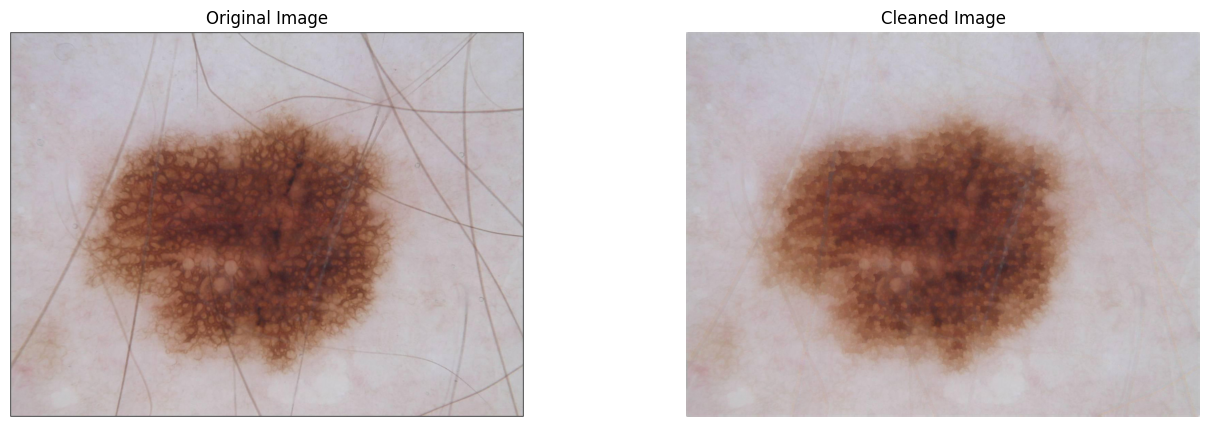

In [ ]:
# Image Idx
# ISIC_0000032_downsampled.jpg
# ISIC_0000030_downsampled.jpg
# ISIC_0000032_downsampled.jpg
# ISIC_0071694.jpg

#####
# kernel for hair removal
# blackhat threshold

# Blur type
# kernel size blur
# Sigma for Gaussian
#####
import cv2

def remove_hair(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a blackhat filter to find the hair
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    # Threshold the blackhat image
    thresh = cv2.threshold(blackhat, 7, 255, cv2.THRESH_BINARY)[1]

    # Inpaint the original image based on the thresholded image
    inpainted_image = cv2.inpaint(image, thresh, 1, cv2.INPAINT_TELEA)
    return inpainted_image


def blurring(image, kernel_size):
  # kernel = np.ones((kernel_size, kernel_size),np.float32)/(kernel_size**2)
  # return cv2.filter2D(image,-1,kernel)
  sigma = 0
  ksize = (kernel_size, kernel_size)
  blurred_img = cv2.GaussianBlur(cleaned_image, ksize, sigma)
  return blurred_img


# Example usage
image = cv2.imread("/content/drive/My Drive/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000019_downsampled.jpg")
cleaned_image = remove_hair(image)
# cleaned_image = blurring(cleaned_image, kernel_size=15)
# cv2.imwrite('output_image.jpg', cleaned_image)

# Convert BGR image to RGB for displaying with Matplotlib
cleaned_image_rgb = cv2.cvtColor(cleaned_image, cv2.COLOR_BGR2RGB)

# Display the original and cleaned images using Matplotlib
plt.figure(figsize=(16, 5))

# Display original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Display cleaned image
plt.subplot(1, 2, 2)
plt.title('Cleaned Image')
plt.imshow(cleaned_image_rgb)
plt.axis('off')

plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_hair(image, kernel_size_tuple=(15,15), blackhat_threshold=18):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a blackhat filter to find the hair
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size_tuple)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    # Threshold the blackhat image
    thresh = cv2.threshold(blackhat, blackhat_threshold, 255, cv2.THRESH_BINARY)[1]

    # Inpaint the original image based on the thresholded image
    inpainted_image = cv2.inpaint(image, thresh, 1, cv2.INPAINT_TELEA)
    return inpainted_image


def blurring(image, kernel_size, blur_func=cv2.medianBlur, sigma=None):
  if blur_func not in (cv2.medianBlur, cv2.GaussianBlur):
    raise ValueError("blur_func must be one of cv2.medianBlur or cv2.GaussianBlur")
  if blur_func == cv2.GaussianBlur:
    blur_args = (image, (kernel_size, kernel_size), sigma)
  else:
    blur_args = (image, kernel_size)
  blurred_img = blur_func(*blur_args)
  return blurred_img

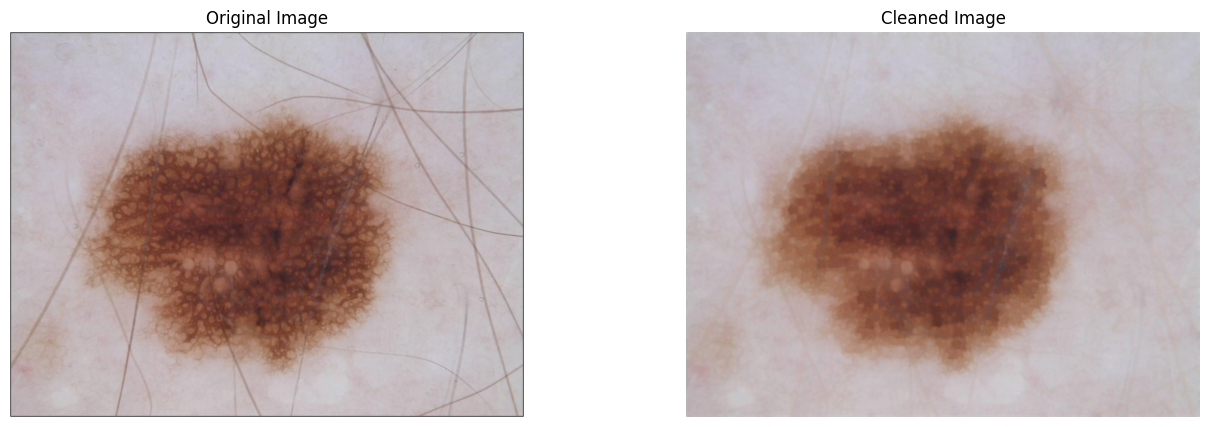

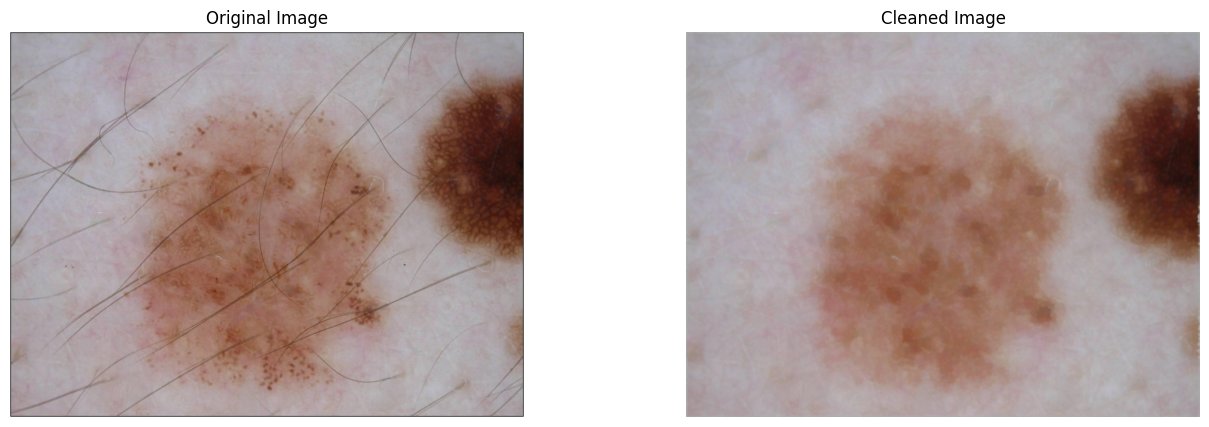

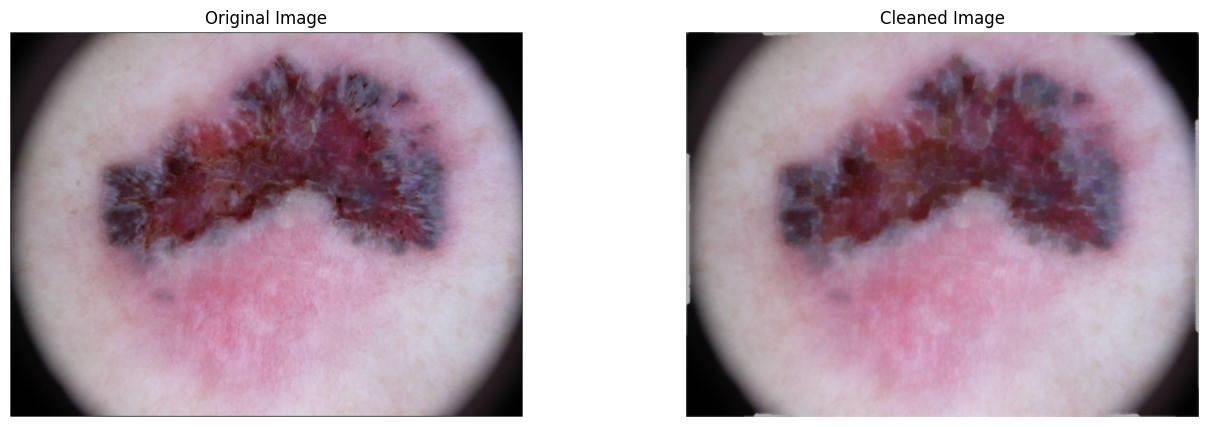

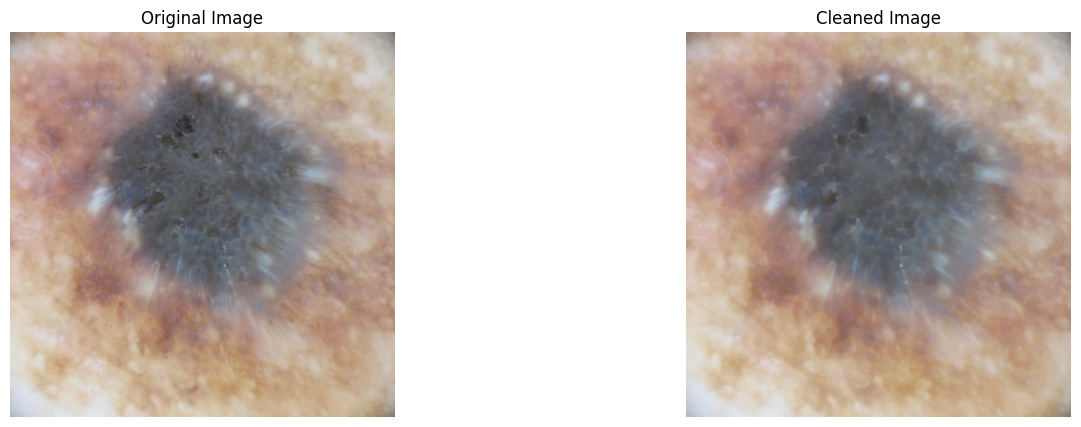

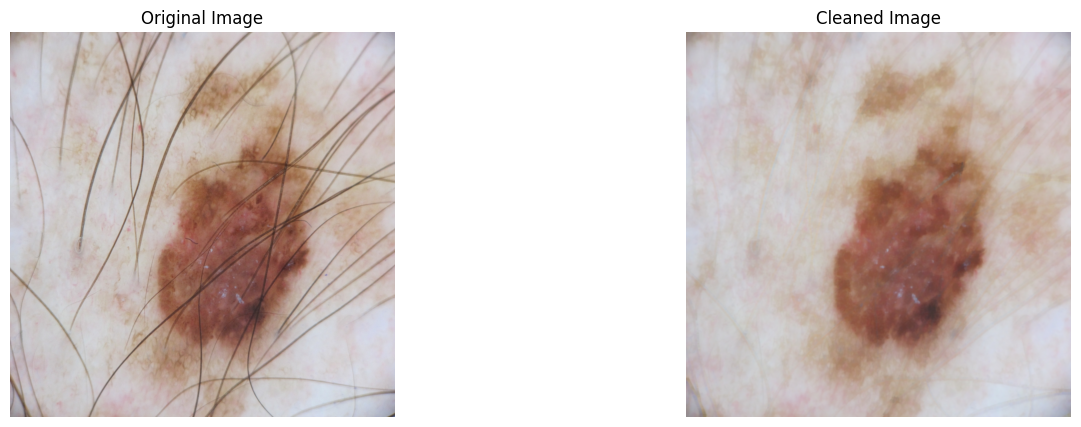

In [ ]:
# Image Idx
# ISIC_0000032_downsampled.jpg
# ISIC_0000030_downsampled.jpg
# ISIC_0000032_downsampled.jpg
# ISIC_0071694.jpg
#ISIC_0071699.jpg

image_path = ["/content/drive/My Drive/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000019_downsampled.jpg",
              "/content/drive/My Drive/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000032_downsampled.jpg",
              "/content/drive/My Drive/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000030_downsampled.jpg",
              "/content/drive/My Drive/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0071694.jpg",
              "/content/drive/My Drive/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0071699.jpg"]
for image_path in image_path:
  image = cv2.imread(image_path)
  cleaned_image = remove_hair(image, kernel_size_tuple=(15,15), blackhat_threshold=9)
  cleaned_image = blurring(cleaned_image, kernel_size=5,blur_func=cv2.GaussianBlur)

  cleaned_image_rgb = cv2.cvtColor(cleaned_image, cv2.COLOR_BGR2RGB)

  # Display the original and cleaned images using Matplotlib
  plt.figure(figsize=(16, 5))

  # Display original image
  plt.subplot(1, 2, 1)
  plt.title('Original Image')
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis('off')

  # Display cleaned image
  plt.subplot(1, 2, 2)
  plt.title('Cleaned Image')
  plt.imshow(cleaned_image_rgb)
  plt.axis('off')

  plt.show()
